# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=0)

2018-03-17 19:15:16,179 INFO    : root         : Using LISA logging configuration:
2018-03-17 19:15:16,180 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

Populating the interactive namespace from numpy and matplotlib


2018-03-17 19:15:17,513 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:15:17,514 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-03-17 19:15:17,515 DEBUG   : JsonConf     :    {u'board': {u'big_core': u'A15', u'cores': [u'A7', u'A7', u'A7', u'A7', u'A15', u'A15', u'A15', u'A15'], u'modules': [u'bl', u'cpufreq']}}
2018-03-17 19:15:17,517 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:15:17,518 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-03-17 19:15:17,520 DEBUG   : JsonConf     :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 78}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1893}}, u'little': {u'cluster': {u'nrg_max': 56}, u'cpu': {u'cap_max': 472, u'nrg_max': 215}}}, u'board': {u'big_core': u'A72', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A72', u'A72'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
2018-03-17 19:15:17,521 DEBUG   : JsonConf     : loading JSON...
2018-03-17 19:15:17,523 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-0

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    "emeter" : {
        "instrument" : "aep",
        "conf" : {
            'resistor_values' : [0.033],
            'device_entry'    : '/dev/ttyACM0'
        },
        "channel_map" : {
            "Device0" : "BAT"
        }
    },
    
    # Preload settings for a specific target
    "board"       : 'hikey960',  # juno - JUNO board with mainline hwmon
    
    "device"      : "2450309301A1C7FB",
    
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal', 'cpufreq'],

    "results_dir" : "scheduling_duration_base",
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
         '0': 302, '1': 301, '2': 304, '3': 301, '4': 136, '5': 136, '6': 137, '7': 136
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency",
             "sched_energy_calc_duration"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-03-17 19:15:18,068 INFO    : TestEnv      : Using base path: /home/leoy/Work/tools/lisa-ml-20171106
2018-03-17 19:15:18,069 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-03-17 19:15:18,071 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-03-17 19:15:18,072 WARNING : TestEnv      : Wipe previous contents of the results folder:
2018-03-17 19:15:18,074 WARNING : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base
2018-03-17 19:15:18,077 INFO    : TestEnv      : External tools using:
2018-03-17 19:15:18,078 INFO    : TestEnv      :    ANDROID_HOME: /home/leoy/Android/Sdk/
2018-03-17 19:15:18,079 INFO    : TestEnv      :    CATAPULT_HOME: /home/leoy/Work/tools/lisa-ml-20171106/tools/catapult
2018-03-17 19:15:18,081 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2018-03-17 19:15:18,082 INFO    : TestEnv      : Connecting Android targe

2018-03-17 19:15:22,214 DEBUG   : CGroup.debug : Initialized [debug, 0, ['blkio', 'devices', 'freezer', 'hugetlb', 'debug']]
2018-03-17 19:15:22,322 DEBUG   : CGroup.debug : Controller debug mounted under: /data/local/tmp/devlib-target/cgroups/devlib_cgh0 (noprefix=False)
2018-03-17 19:15:22,324 DEBUG   : cgroups.debug : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-03-17 19:15:22,386 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh0
2018-03-17 19:15:24,668 INFO    : TestEnv      : Attempting to read energy model from target
2018-03-17 19:15:25,477 INFO    : TestEnv      : Topology:
2018-03-17 19:15:25,478 INFO    : TestEnv      :    [[0, 1, 2, 3], [4, 5, 6, 7]]
2018-03-17 19:15:25,599 INFO    : TestEnv      : Loading default EM:
2018-03-17 19:15:25,600 INFO    : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/libs/utils/platforms/hikey960.json
2018-03-17 19:15:25,602 DEBUG   : JsonConf     : loading JSON...
20

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [5]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
        
        'task_per50': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=50,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:15:26,140 INFO    : Workload     : Setup new workload simple
2018-03-17 19:15:26,213 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:15:26,215 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:15:26,216 INFO    : Workload     : ------------------------
2018-03-17 19:15:26,219 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:15:26,220 INFO    : Workload     :  | loops count: 1
2018-03-17 19:15:26,222 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:15:26,223 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-03-17 19:15:26,225 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]
2018-03-17 19:15:26,226 INFO    : Workload     : ------------------------
2018-03-17 19:15:26,228 INFO    : Workload     : task [task_per50], sched: {'policy': 'OTHER'}
2018-03-17 19:15:26,229 INFO    : Workload     :  | loops count:

The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-01-19 11:32:15,121 INFO    : root         : #### Setup FTrace
2018-01-19 11:32:18,232 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:18,308 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:32:18,410 INFO    : root         : #### Start energy sampling
2018-01-19 11:32:18,412 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:32:18,422 INFO    : root         : #### Start RTApp execution
2018-01-19 11:32:18,425 INFO    : Workload     : Workload execution START:
2018-01-19 11:32:18,426 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:32:28,596 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:32:28,598 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:32:29,004 INFO    : root         : #### Stop FTrace
2018-01-19 11:32:29,006 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:29,259 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:32:31,207 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


## Collected results

In [8]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2018-01-19 11:32:31,223 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per5": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 2000, 
                    "run": 50, 
                    "timer": {
                        "period": 5000, 
                        "ref": "task_per5"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [9]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2018-01-19 11:32:31,363 INFO    : root         : #### Setup FTrace
2018-01-19 11:32:34,439 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:34,542 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-01-19 11:32:34,641 INFO    : root         : #### Start energy sampling
2018-01-19 11:32:34,643 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-L2pKh8
2018-01-19 11:32:34,661 INFO    : root         : #### Start RTApp execution
2018-01-19 11:32:34,663 INFO    : Workload     : Workload execution START:
2018-01-19 11:32:34,664 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-01-19 11:32:44,863 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-01-19 11:32:44,865 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-L2pKh8/0000000000
2018-01-19 11:32:45,253 INFO    : root         : #### Stop FTrace
2018-01-19 11:32:45,254 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-01-19 11:32:45,491 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-01-19 11:32:47,441 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json
2018-01-19 11:32:47,444 INFO    : root         : Content of the output folder /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base


total 6808
drwxrwxr-x  2 leoy leoy    4096 Jan 19 11:32 .
drwxrwxr-x 13 leoy leoy    4096 Jan 19 11:31 ..
-rw-rw-r--  1 leoy leoy      37 Jan 19 11:32 energy.json
-rw-rw-r--  1 leoy leoy     170 Jan 19 11:32 output.log
-rw-rw-r--  1 leoy leoy    1527 Jan 19 11:32 platform.json
-rw-r--r--  1 leoy leoy  248160 Jan 19 11:32 rt-app-task_per5-0.log
-rw-rw-r--  1 leoy leoy 1834602 Jan 19 11:32 samples.csv
-rw-r--r--  1 leoy leoy     569 Jan 19 11:32 simple_00.json
-rw-r--r--  1 leoy leoy 4861952 Jan 19 11:32 trace.dat


In [10]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2018-01-19 11:32:47,567 INFO    : root         : Energy: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json


{
    "Device0": 23.732979492318023
}


In [11]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2018-01-19 11:32:47,692 INFO    : root         : Platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 74, 
        "parts": [
            4, 
            9, 
            74
        ], 
        "rc": null, 
        "release": "4.9.74-04139-ge64eb0a", 
        "sha1": "e64eb0a", 
        "version": "105 SMP PREEMPT Fri Jan 19 11:30:05 CST 2018", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
        

In [6]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

## 1% Workload

More information on visualization and trace inspection can be found in **examples/trappy**.

In [7]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:15:37,542 INFO    : Workload     : Setup new workload simple
2018-03-17 19:15:37,631 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:15:37,634 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:15:37,635 INFO    : Workload     : ------------------------
2018-03-17 19:15:37,636 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:15:37,638 INFO    : Workload     :  | loops count: 1
2018-03-17 19:15:37,639 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:15:37,640 INFO    : Workload     : |  period     5000 [us], duty_cycle   1 %
2018-03-17 19:15:37,642 INFO    : Workload     : |  run_time     50 [us], sleep_time   4950 [us]


In [8]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:15:38,207 INFO    : root         : #### Setup FTrace
2018-03-17 19:15:41,277 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:15:41,369 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:15:41,481 INFO    : root         : #### Start energy sampling
2018-03-17 19:15:41,482 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:15:41,496 INFO    : root         : #### Start RTApp execution
2018-03-17 19:15:41,498 INFO    : Workload     : Workload execution START:
2018-03-17 19:15:41,499 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:15:51,784 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:15:51,786 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:15:52,141 INFO    : root         : #### Stop FTrace
2018-03-17 19:15:52,142 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:15:52,384 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:15:54,325 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [9]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


## RTApp task performance plots

2018-03-17 19:15:55,942 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:15:55,943 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:15:56,613 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.86, std: 0.06


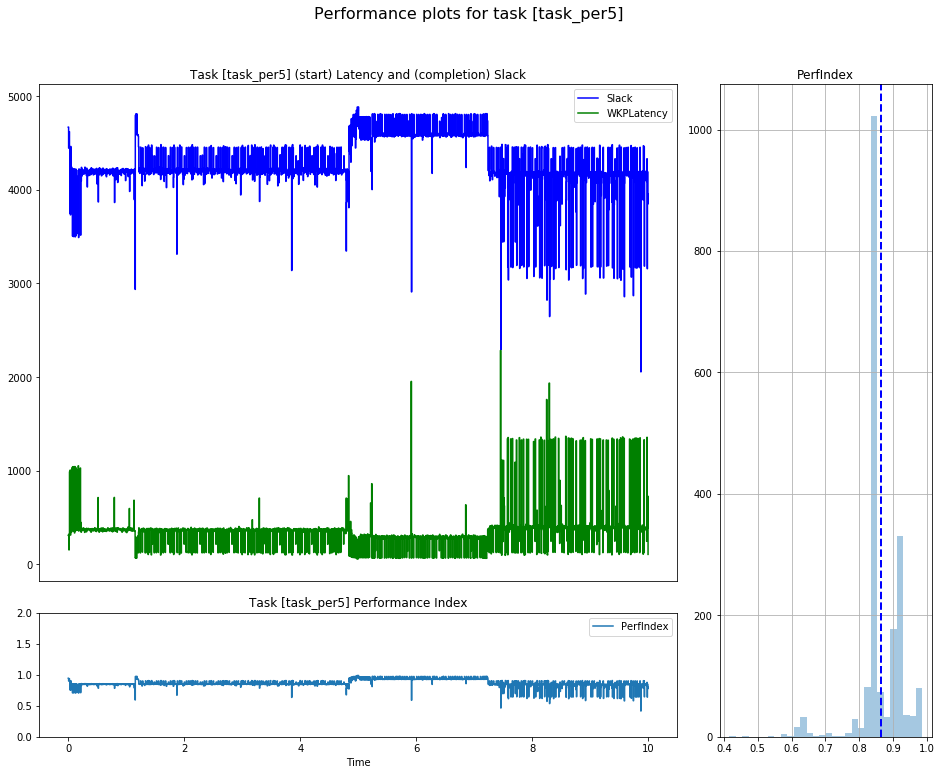

In [10]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [11]:
# Analyse CPU utilization standard devation
def analysis_energy_calculation_duration():

    df = trace.data_frame.trace_event('sched_energy_calc_duration')
    
    if df.empty:
        return
    
    calc_duration_df = pd.DataFrame(
        {
            'max': [int(df['duration'].max())],
            'min': [int(df['duration'].min())],
            'mean': [int(df['duration'].mean())],
        },
    )
    
    return calc_duration_df

In [12]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:15:58,013 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:15:58,014 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib']
2018-03-17 19:15:58,019 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f5725c45750> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725ff7210> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:15:58,605 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:15:58,606 DEBUG   : Trace        :  - cpu_freque

2018-03-17 19:15:58,888 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:15:58,890 DEBUG   : Trace        :    trace_event
2018-03-17 19:15:58,892 DEBUG   : Analysis     :    frequency
2018-03-17 19:15:58,893 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:15:58,900 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f57259e6d50>] local data frames
2018-03-17 19:15:58,903 DEBUG   : Trace        :    activations_df
2018-03-17 19:15:58,905 DEBUG   : Trace        :    latency_df
2018-03-17 19:15:58,907 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:15:58,909 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:15:58,911 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:15:58,912 DEBUG   : Trace        :    trace_event
2018-03-17 19:15:58,913 DEBUG   : Analysis     :    latency


In [13]:
analysis_energy_calculation_duration()

,max,mean,min
0,40104,10823,2604


# 5% workload

In [14]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=5,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:16:03,110 INFO    : Workload     : Setup new workload simple
2018-03-17 19:16:03,209 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:16:03,211 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:16:03,212 INFO    : Workload     : ------------------------
2018-03-17 19:16:03,213 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:16:03,214 INFO    : Workload     :  | loops count: 1
2018-03-17 19:16:03,215 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:16:03,216 INFO    : Workload     : |  period     5000 [us], duty_cycle   5 %
2018-03-17 19:16:03,217 INFO    : Workload     : |  run_time    250 [us], sleep_time   4750 [us]


In [15]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:16:03,459 INFO    : root         : #### Setup FTrace
2018-03-17 19:16:06,598 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:06,707 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:16:06,831 INFO    : root         : #### Start energy sampling
2018-03-17 19:16:06,833 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:16:06,846 INFO    : root         : #### Start RTApp execution
2018-03-17 19:16:06,848 INFO    : Workload     : Workload execution START:
2018-03-17 19:16:06,849 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:16:17,171 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:16:17,174 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:16:17,528 INFO    : root         : #### Stop FTrace
2018-03-17 19:16:17,529 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:17,808 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:16:19,802 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [16]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:200: UserWarning: Cached data is from another trace, invalidating cache.
  warnings.warn(warnstr)


2018-03-17 19:16:20,994 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:16:20,995 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:16:21,312 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.56, std: 0.05


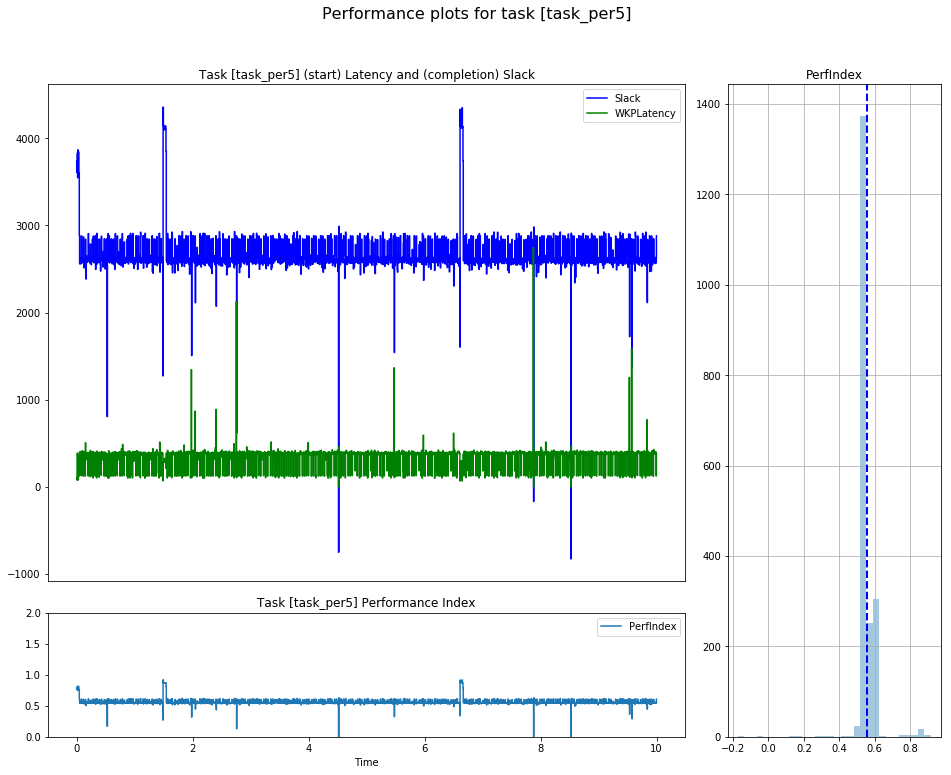

In [17]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [18]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:16:22,465 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:16:22,466 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:16:22,467 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f5725c89350> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725ad6550> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:16:22,941 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:16:22,942 DEBUG   : Trac

2018-03-17 19:16:23,130 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:16:23,132 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:16:23,133 DEBUG   : Trace        :    trace_event
2018-03-17 19:16:23,135 DEBUG   : Analysis     :    frequency
2018-03-17 19:16:23,136 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:16:23,138 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f5725b3f490>] local data frames
2018-03-17 19:16:23,140 DEBUG   : Trace        :    activations_df
2018-03-17 19:16:23,142 DEBUG   : Trace        :    latency_df
2018-03-17 19:16:23,143 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:16:23,145 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:16:23,147 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:16:23,148 DEBUG   : Trace        :    trace_event
2018-03-17 19:16:23,149 DEBUG   : Analysis     :    latency


In [19]:
analysis_energy_calculation_duration()

,max,mean,min
0,38021,11924,4167


# 10% workload

In [20]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:16:23,294 INFO    : Workload     : Setup new workload simple
2018-03-17 19:16:23,391 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:16:23,392 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:16:23,394 INFO    : Workload     : ------------------------
2018-03-17 19:16:23,395 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:16:23,396 INFO    : Workload     :  | loops count: 1
2018-03-17 19:16:23,398 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:16:23,399 INFO    : Workload     : |  period     5000 [us], duty_cycle  10 %
2018-03-17 19:16:23,401 INFO    : Workload     : |  run_time    500 [us], sleep_time   4500 [us]


In [21]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:16:23,480 INFO    : root         : #### Setup FTrace
2018-03-17 19:16:26,574 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:26,667 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:16:26,790 INFO    : root         : #### Start energy sampling
2018-03-17 19:16:26,792 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:16:26,807 INFO    : root         : #### Start RTApp execution
2018-03-17 19:16:26,809 INFO    : Workload     : Workload execution START:
2018-03-17 19:16:26,811 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:16:37,111 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:16:37,113 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:16:37,464 INFO    : root         : #### Stop FTrace
2018-03-17 19:16:37,466 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:37,734 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:16:39,789 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [22]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:16:41,083 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:16:41,085 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:16:41,338 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.56, std: 0.08


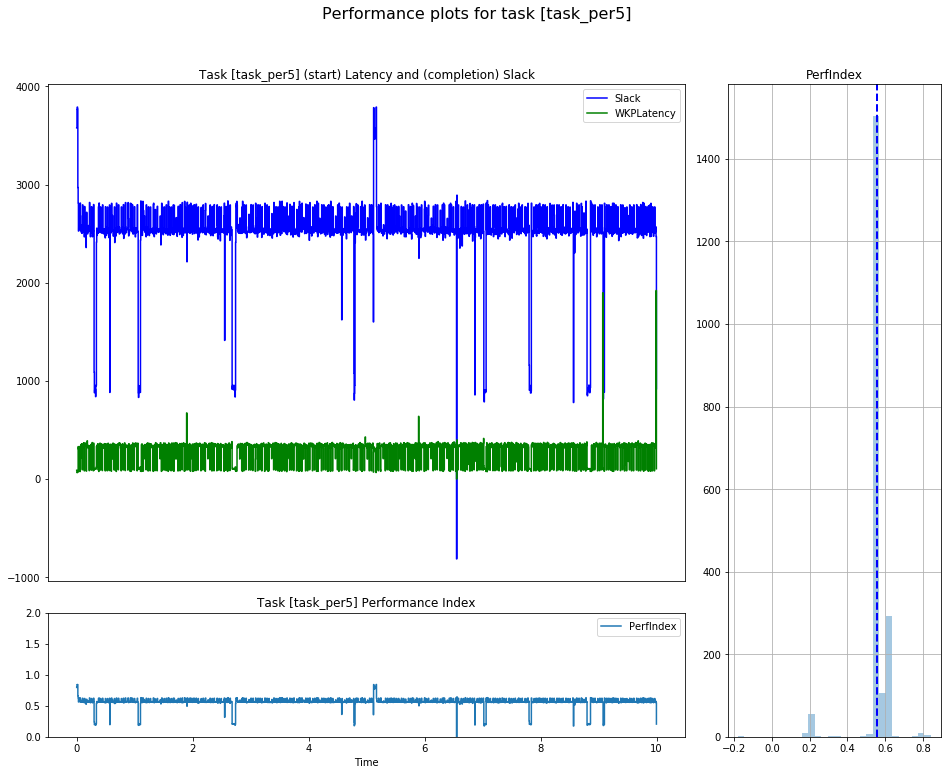

In [23]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [24]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:16:42,479 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:16:42,481 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:16:42,483 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f5725f23990> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725f23750> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:16:42,998 DEBUG   : Trace        : Events found on trace:
2018-03-17 19:

2018-03-17 19:16:43,200 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:16:43,201 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:16:43,202 DEBUG   : Trace        :    trace_event
2018-03-17 19:16:43,203 DEBUG   : Analysis     :    frequency
2018-03-17 19:16:43,204 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:16:43,206 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f5725c897d0>] local data frames
2018-03-17 19:16:43,207 DEBUG   : Trace        :    activations_df
2018-03-17 19:16:43,208 DEBUG   : Trace        :    latency_df
2018-03-17 19:16:43,210 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:16:43,211 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:16:43,213 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:16:43,214 DEBUG   : Trace        :    trace_event
2018-03-17 19:16:43,216 DEBUG   : Analysis     :    latency


In [25]:
analysis_energy_calculation_duration()

,max,mean,min
0,35938,10931,4167


# 20% Workload

In [26]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:16:43,341 INFO    : Workload     : Setup new workload simple
2018-03-17 19:16:43,439 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:16:43,440 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:16:43,443 INFO    : Workload     : ------------------------
2018-03-17 19:16:43,445 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:16:43,447 INFO    : Workload     :  | loops count: 1
2018-03-17 19:16:43,448 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:16:43,450 INFO    : Workload     : |  period     5000 [us], duty_cycle  20 %
2018-03-17 19:16:43,451 INFO    : Workload     : |  run_time   1000 [us], sleep_time   4000 [us]


In [27]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:16:43,535 INFO    : root         : #### Setup FTrace
2018-03-17 19:16:46,665 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:46,775 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:16:46,907 INFO    : root         : #### Start energy sampling
2018-03-17 19:16:46,909 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:16:46,926 INFO    : root         : #### Start RTApp execution
2018-03-17 19:16:46,933 INFO    : Workload     : Workload execution START:
2018-03-17 19:16:46,940 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:16:57,195 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:16:57,197 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:16:57,543 INFO    : root         : #### Stop FTrace
2018-03-17 19:16:57,545 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:16:57,816 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:16:59,750 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [28]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:17:00,892 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:17:00,893 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:17:01,120 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.45, std: 0.05


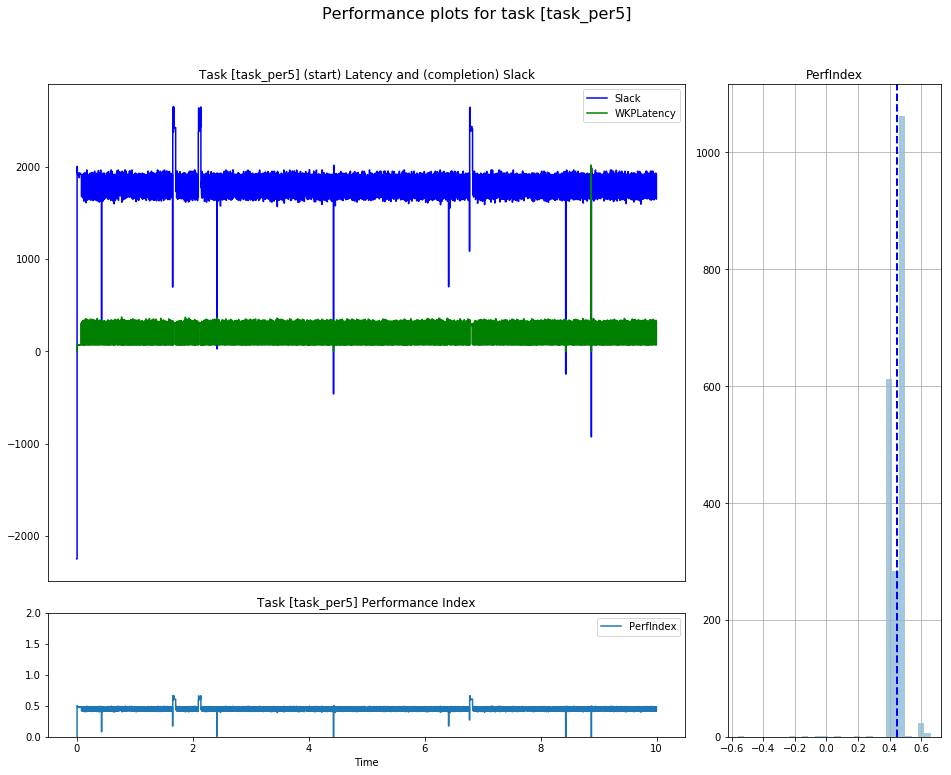

In [29]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [30]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:17:02,135 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:17:02,136 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:17:02,138 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f5725cc1390> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725f3be90> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:17:02,634 DEBUG   : Trace        : Events found 

2018-03-17 19:17:02,828 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:17:02,830 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:17:02,831 DEBUG   : Trace        :    trace_event
2018-03-17 19:17:02,833 DEBUG   : Analysis     :    frequency
2018-03-17 19:17:02,834 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:17:02,836 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f5725eada90>] local data frames
2018-03-17 19:17:02,841 DEBUG   : Trace        :    activations_df
2018-03-17 19:17:02,843 DEBUG   : Trace        :    latency_df
2018-03-17 19:17:02,844 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:17:02,845 DEBUG   : Trace        :    latency_wakeup_df
2018-03-17 19:17:02,847 DEBUG   : Trace        :    runtimes_df
2018-03-17 19:17:02,848 DEBUG   : Trace        :    trace_event
2018-03-17 19:17:02,849 DEBUG   : Analysis     :    latency


In [31]:
analysis_energy_calculation_duration()

,max,mean,min
0,33854,10785,3125


# 30% Workload

In [32]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=30,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:17:02,981 INFO    : Workload     : Setup new workload simple
2018-03-17 19:17:03,075 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:17:03,077 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:17:03,078 INFO    : Workload     : ------------------------
2018-03-17 19:17:03,079 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:17:03,080 INFO    : Workload     :  | loops count: 1
2018-03-17 19:17:03,081 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:17:03,082 INFO    : Workload     : |  period     5000 [us], duty_cycle  30 %
2018-03-17 19:17:03,083 INFO    : Workload     : |  run_time   1500 [us], sleep_time   3500 [us]


In [33]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:17:03,159 INFO    : root         : #### Setup FTrace
2018-03-17 19:17:06,304 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:17:06,430 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:17:06,558 INFO    : root         : #### Start energy sampling
2018-03-17 19:17:06,560 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:17:06,578 INFO    : root         : #### Start RTApp execution
2018-03-17 19:17:06,580 INFO    : Workload     : Workload execution START:
2018-03-17 19:17:06,585 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:17:16,859 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:17:16,861 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:17:17,201 INFO    : root         : #### Stop FTrace
2018-03-17 19:17:17,203 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:17:17,520 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:17:19,571 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [34]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:17:20,725 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:17:20,726 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:17:20,958 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.35, std: 0.05


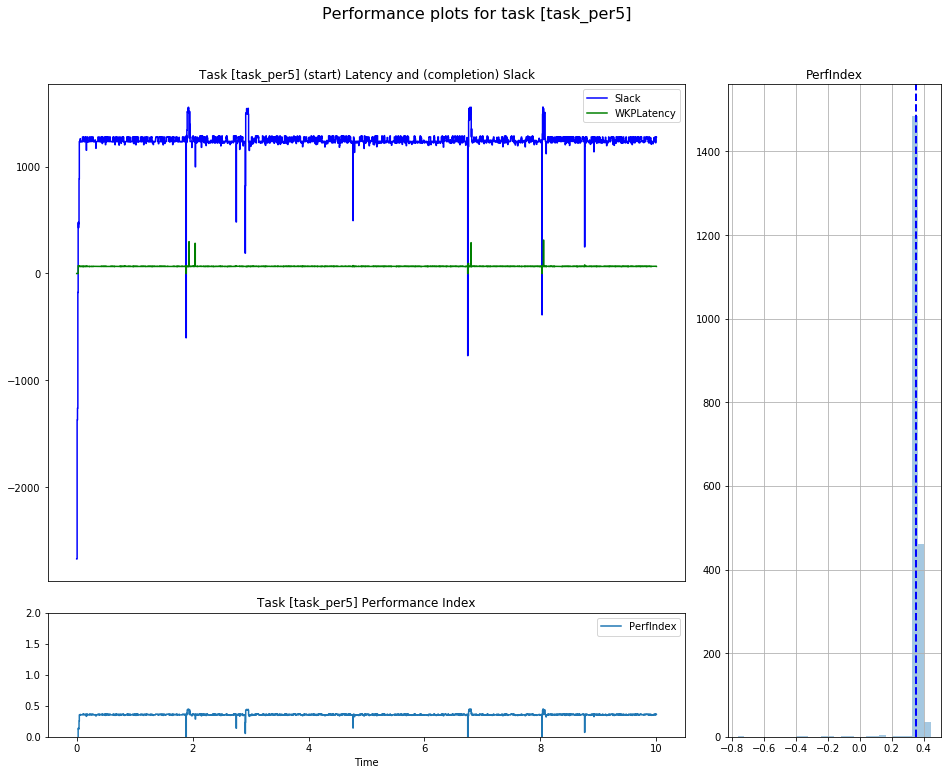

In [35]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [36]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:17:21,879 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:17:21,883 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:17:21,887 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f5725f48d90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725f48410> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:17:22,406 DEBUG   : Trac

2018-03-17 19:17:22,569 DEBUG   : Analysis     :    idle
2018-03-17 19:17:22,570 DEBUG   : Analysis     : Filename: frequency_analysis
2018-03-17 19:17:22,571 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f5725bb2f10>] local data frames
2018-03-17 19:17:22,572 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:17:22,573 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:17:22,574 DEBUG   : Trace        :    trace_event
2018-03-17 19:17:22,574 DEBUG   : Analysis     :    frequency
2018-03-17 19:17:22,575 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:17:22,577 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f5725bb2c90>] local data frames
2018-03-17 19:17:22,578 DEBUG   : Trace        :    activations_df
2018-03-17 19:17:22,579 DEBUG   : Trace        :    latency_df
2018-03-17 19:17:22,580 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:17:

In [37]:
analysis_energy_calculation_duration()

,max,mean,min
0,40625,11139,4166


# 40% Workload

In [38]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=40,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-03-17 19:17:22,719 INFO    : Workload     : Setup new workload simple
2018-03-17 19:17:22,805 INFO    : Workload     : Workload duration defined by longest task
2018-03-17 19:17:22,807 INFO    : Workload     : Default policy: SCHED_OTHER
2018-03-17 19:17:22,808 INFO    : Workload     : ------------------------
2018-03-17 19:17:22,809 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-03-17 19:17:22,813 INFO    : Workload     :  | loops count: 1
2018-03-17 19:17:22,814 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (2000 loops)
2018-03-17 19:17:22,815 INFO    : Workload     : |  period     5000 [us], duty_cycle  40 %
2018-03-17 19:17:22,816 INFO    : Workload     : |  run_time   2000 [us], sleep_time   3000 [us]


In [39]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-03-17 19:17:22,879 INFO    : root         : #### Setup FTrace
2018-03-17 19:17:26,003 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:17:26,115 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-03-17 19:17:26,223 INFO    : root         : #### Start energy sampling
2018-03-17 19:17:26,225 DEBUG   : EnergyProbeInstrument : /usr/local/sbin/caiman -d /dev/ttyACM0 -l -r 0:33  /tmp/eprobe-caiman-Kzm8fz
2018-03-17 19:17:26,244 INFO    : root         : #### Start RTApp execution
2018-03-17 19:17:26,246 INFO    : Workload     : Workload execution START:
2018-03-17 19:17:26,249 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-03-17 19:17:36,501 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/energy.json
2018-03-17 19:17:36,503 DEBUG   : EnergyProbeInstrument : Parsing raw data file: /tmp/eprobe-caiman-Kzm8fz/0000000000
2018-03-17 19:17:36,835 INFO    : root         : #### Stop FTrace
2018-03-17 19:17:36,836 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-03-17 19:17:37,114 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat
2018-03-17 19:17:39,165 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/platform.json


In [40]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

2018-03-17 19:17:40,321 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-03-17 19:17:40,322 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-03-17 19:17:40,560 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.50, std: 0.08


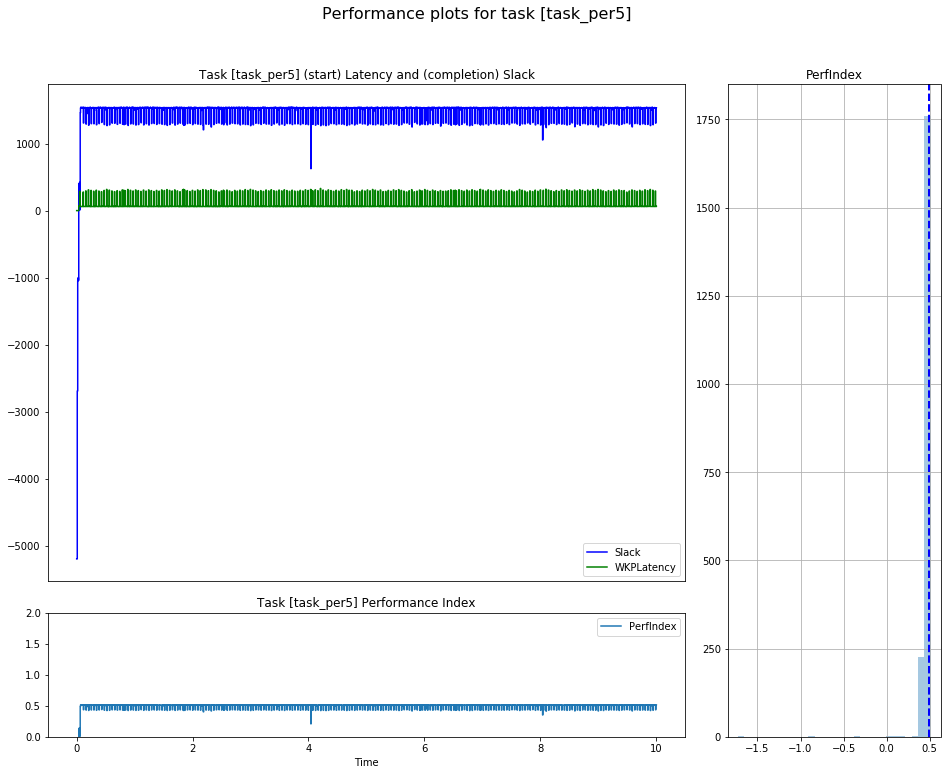

In [41]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [42]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-03-17 19:17:41,653 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_base/trace.dat]...
2018-03-17 19:17:41,656 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-03-17 19:17:41,658 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f57259e6290> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f5725cf6890> from cache, reading it from trace
  warnings.warn(warnstr)
2018-03-17 19:

2018-03-17 19:17:42,327 DEBUG   : Analysis     :    idle
2018-03-17 19:17:42,329 DEBUG   : Analysis     : Filename: frequency_analysis
2018-03-17 19:17:42,331 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f57262a00d0>] local data frames
2018-03-17 19:17:42,332 DEBUG   : Trace        :    cluster_frequency_residency
2018-03-17 19:17:42,333 DEBUG   : Trace        :    cpu_frequency_residency
2018-03-17 19:17:42,334 DEBUG   : Trace        :    trace_event
2018-03-17 19:17:42,336 DEBUG   : Analysis     :    frequency
2018-03-17 19:17:42,337 DEBUG   : Analysis     : Filename: latency_analysis
2018-03-17 19:17:42,338 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f57262a0150>] local data frames
2018-03-17 19:17:42,340 DEBUG   : Trace        :    activations_df
2018-03-17 19:17:42,341 DEBUG   : Trace        :    latency_df
2018-03-17 19:17:42,344 DEBUG   : Trace        :    latency_preemption_df
2018-03-17 19:17:

In [43]:
analysis_energy_calculation_duration()

,max,mean,min
0,44271,11223,2604
